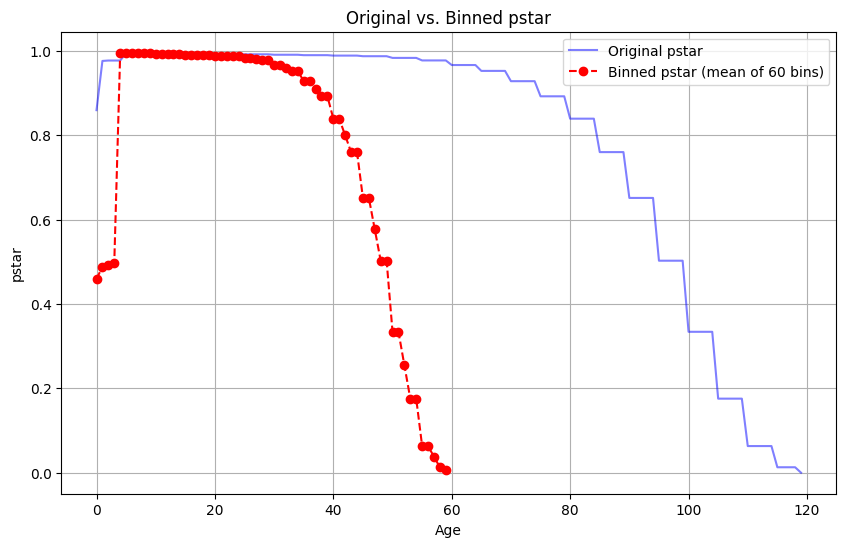

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

vec1 = pd.read_csv('demog_vectors.csv')
vec1 = vec1.rename_axis('age').reset_index()
new_max_age = 60
old_max_age = vec1['age'].max()
scale_factor = new_max_age / old_max_age
scale_factor = 1
other_para = ['rho', 'pstar', 'mortparms']

bins = pd.cut(vec1['age'], bins=new_max_age)

binned_vec = pd.DataFrame()

for col in other_para:
    binned_col = vec1.groupby(bins, observed=False).agg({col: 'mean'}).reset_index()
    binned_col[col] = binned_col[col] * scale_factor
    binned_vec[col] = binned_col[col]

binned_vec = binned_vec.rename_axis('age_new').reset_index()
# lower survival probability for infants (0-3 years)
binned_vec.loc[binned_vec['age_new'] <= 3, 'pstar'] *= 0.5
    
bin_centers = [interval.mid for interval in binned_col['age']]
plt.figure(figsize=(10, 6))
plt.plot(vec1['age'], vec1['pstar'], label='Original pstar', color='blue', alpha=0.5)

plt.plot(binned_vec['age_new'], binned_vec['pstar'], label='Binned pstar (mean of 60 bins)', color='red', linestyle='--', marker='o')

plt.title('Original vs. Binned pstar')
plt.xlabel('Age')
plt.ylabel('pstar')
plt.legend()
plt.grid(True)
plt.show()


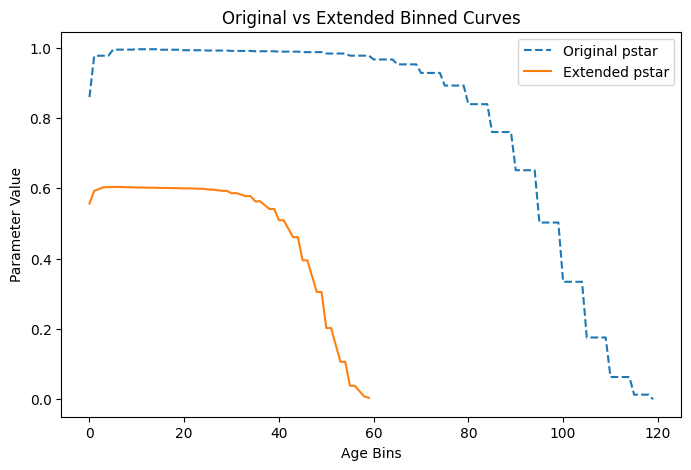

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

vec1 = pd.read_csv('demog_vectors.csv')
vec1 = vec1.rename_axis('age').reset_index()

new_max_age = 60

other_para = ['rho', 'pstar', 'mortparms']

bins = pd.cut(vec1['age'], bins=new_max_age)
binned_vec = pd.DataFrame()

for col in other_para:
    binned_col = vec1.groupby(bins, observed=False).agg({col: 'mean'}).reset_index()
    binned_vec[col] = binned_col[col]


def extend_tail(values, start_idx, decay_rate=0.5):
    for i in range(start_idx, len(values)):
        values[i] = values[i] * np.exp(-decay_rate)
        # values[i] = values[i] * 1
    return values

start_idx = int(0.02 * len(binned_vec))  
start_idx = 0

for col in ['pstar']:
    binned_vec[col] = extend_tail(binned_vec[col].values, start_idx)


bin_centers = [interval.mid for interval in binned_col['age']]
binned_vec = binned_vec.rename_axis('age_new').reset_index()

plt.figure(figsize=(8, 5))
for col in ['pstar']:
    plt.plot(vec1.index, vec1[col], label=f'Original {col}', linestyle='dashed')
    plt.plot(binned_vec.index, binned_vec[col], label=f'Extended {col}')

plt.xlabel('Age Bins')
plt.ylabel('Parameter Value')
plt.title('Original vs Extended Binned Curves')
plt.legend()
plt.show()

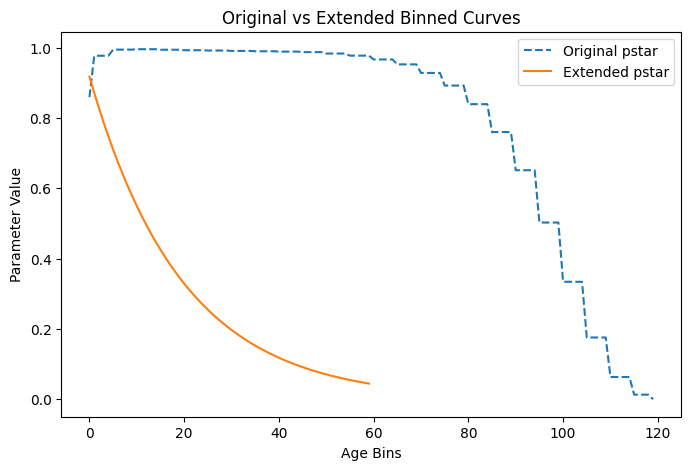

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

vec1 = pd.read_csv('demog_vectors.csv')
vec1 = vec1.rename_axis('age').reset_index()

new_max_age = 60
other_para = ['rho', 'pstar', 'mortparms']

bins = pd.cut(vec1['age'], bins=new_max_age)
binned_vec = pd.DataFrame()

for col in other_para:
    binned_col = vec1.groupby(bins, observed=False).agg({col: 'mean'}).reset_index()
    binned_vec[col] = binned_col[col]

def smooth_tail(values, start_idx, decay_factor=0.95):
    for i in range(start_idx, len(values)):
        values[i] = values[i - 1] * decay_factor if i > 0 else values[i]
    return values

start_idx = int(0.02 * len(binned_vec))  
start_idx = 0

for col in ['pstar']:
    binned_vec[col] = smooth_tail(binned_vec[col].values, start_idx)

bin_centers = [interval.mid for interval in binned_col['age']]
binned_vec = binned_vec.rename_axis('age_new').reset_index()

plt.figure(figsize=(8, 5))
for col in ['pstar']:
    plt.plot(vec1.index, vec1[col], label=f'Original {col}', linestyle='dashed')
    plt.plot(binned_vec.index, binned_vec[col], label=f'Extended {col}')

plt.xlabel('Age Bins')
plt.ylabel('Parameter Value')
plt.title('Original vs Extended Binned Curves')
plt.legend()
plt.show()
